In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:
# data = "https://archive.ics.uci.edu/static/public/222/bank+marketing.zip"
# !python -m wget $data

In [3]:
df = pd.read_csv("bank+marketing/bank/bank-full.csv", sep=";")
df = df.drop(["default", "loan"], axis=1)
df["y"] = (df.y == "yes").astype(int)

df.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,0


In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_valid = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.y.values
y_valid = df_valid.y.values
y_test = df_test.y.values

del df_train['y']
del df_valid['y']
del df_test['y']

In [5]:
len(df_train), len(df_valid), len(df_test)

(27126, 9042, 9043)

In [6]:
len(y_train), len(y_valid), len(y_test)

(27126, 9042, 9043)

### No. 1

In [8]:
auc_scores = []

numerical = df_train.select_dtypes(include="number").columns

for num in numerical:
    
    auc = roc_auc_score(y_train, df_train[num])
    
    if auc < 0.5:
        df_train[num] = -df_train[num]
        print(f" Inverted features: {num} with AUC: {auc}")
    else:
        print(f" Features: {num} with AUC: {auc}")

 Inverted features: age with AUC: 0.48781428247265596
 Features: balance with AUC: 0.5888313805382317
 Inverted features: day with AUC: 0.474042117616092
 Features: duration with AUC: 0.8147002759670778
 Inverted features: campaign with AUC: 0.42854569843178414
 Features: pdays with AUC: 0.5901276247352144
 Features: previous with AUC: 0.5985653242764153


### No. 2

In [10]:
train_dict = df_train.to_dict(orient="records")

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

valid_dict = df_valid.to_dict(orient="records")
X_valid = dv.transform(valid_dict)

y_pred = model.predict_proba(X_valid)[:, 1]

In [11]:
roc_auc_score(y_valid, y_pred).round(2)

0.89

### No. 3

In [13]:
scores = []
thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_valid == 1)
    actual_negative = (y_valid == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    precision = tp / (tp + fp) if (tp + fp) > 0 else float('nan')
    recall = tp / (tp + fn) if (tp + fn) > 0 else float('nan')

    scores.append((t, tp, fp, fn, tn, precision, recall))

In [14]:
columns = ["thresholds", "tp", "fp", "fn", "tn", "precision", "recall"]
 
df_scores = pd.DataFrame(scores, columns=columns)
df_scores[ : : 10]

,thresholds,tp,fp,fn,tn,precision,recall
0,0.0,1098,7944,0,0,0.121433,1.000000
10,0.1,1011,2531,87,5413,0.285432,0.920765
20,0.2,833,1132,265,6812,0.423919,0.758652
30,0.3,671,664,427,7280,0.502622,0.611111
40,0.4,554,424,544,7520,0.566462,0.504554
50,0.5,474,291,624,7653,0.619608,0.431694
60,0.6,383,211,715,7733,0.644781,0.348816
70,0.7,295,146,803,7798,0.668934,0.268670
80,0.8,205,96,893,7848,0.681063,0.186703
90,0.9,109,52,989,7892,0.677019,0.099271


Honestly, I have no idea why my intersection is off as provided answers but I think the code seems fine

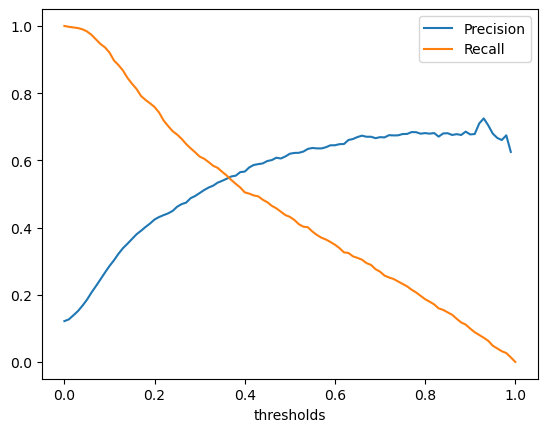

In [15]:
plt.plot(df_scores.thresholds, df_scores.precision, label = "Precision")
plt.plot(df_scores.thresholds, df_scores.recall, label = "Recall")

plt.xlabel("thresholds")

plt.legend()

### No 4

In [17]:
df_scores["f1-score"] = 2*((df_scores.precision * df_scores.recall) / (df_scores.precision + df_scores.recall))

df_scores

,thresholds,tp,fp,fn,tn,precision,recall,f1-score
0,0.00,1098,7944,0,0,0.121433,1.000000,0.216568
1,0.01,1095,7543,3,401,0.126765,0.997268,0.224938
2,0.02,1093,6783,5,1161,0.138776,0.995446,0.243593
3,0.03,1091,6123,7,1821,0.151234,0.993625,0.262512
4,0.04,1087,5415,11,2529,0.167179,0.989982,0.286053
...,...,...,...,...,...,...,...,...
96,0.96,44,22,1054,7922,0.666667,0.040073,0.075601
97,0.97,35,18,1063,7926,0.660377,0.031876,0.060817
98,0.98,29,14,1069,7930,0.674419,0.026412,0.050833
99,0.99,15,9,1083,7935,0.625000,0.013661,0.026738


In [18]:
f1_score_max = df_scores["f1-score"].max()

df_scores[df_scores["f1-score"] == f1_score_max]

,thresholds,tp,fp,fn,tn,precision,recall,f1-score
34,0.34,634,554,464,7390,0.53367,0.577413,0.554681
